# <center>INFO557: Final Project
### <center>Namig Abbasov 

## Import Libraries and Load Data 

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import zipfile
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input,Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import os
import tensorflow as tf

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [3]:
train_df = pd.read_csv("train.csv")
dev_df = pd.read_csv("dev.csv")

## Explanatory Data Analysis

In [4]:
### prepare labels and train and dev sets 

label_cols = ["admiration", "amusement", "gratitude", "love", "pride", "relief", "remorse"]
X_train_text = train_df["text"].astype(str)
y_train = train_df[label_cols].values
X_dev_text = dev_df["text"].astype(str)
y_dev = dev_df[label_cols].values

In [5]:
### Shape and column overview
print(f"Train shape: {train_df.shape}")
print(f"Dev shape: {dev_df.shape}")
print("\nTrain columns:", train_df.columns.tolist())

Train shape: (25196, 8)
Dev shape: (3149, 8)

Train columns: ['text', 'admiration', 'amusement', 'gratitude', 'love', 'pride', 'relief', 'remorse']


In [6]:
### Check for missing values
print("\n Missing Values in Train Set:")
print(train_df.isnull().sum())


 Missing Values in Train Set:
text          0
admiration    0
amusement     0
gratitude     0
love          0
pride         0
relief        0
remorse       0
dtype: int64


In [7]:
### Check class imbalance for each label
print("\nLabel Distribution - Total Positive Instances in Training Set:")
print(train_df[label_cols].sum().sort_values(ascending=False))


Label Distribution - Total Positive Instances in Training Set:
admiration    4130
gratitude     2662
amusement     2328
love          2086
remorse        545
relief         153
pride          111
dtype: int64


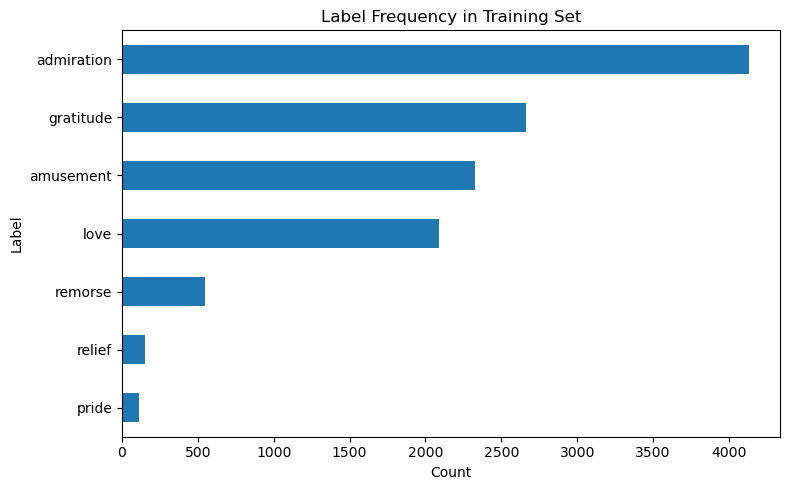

In [8]:
### Plot class imbalance
train_df[label_cols].sum().sort_values().plot(kind='barh', figsize=(8, 5), title="Label Frequency in Training Set")
plt.xlabel("Count")
plt.ylabel("Label")
plt.tight_layout()
plt.show()

In [9]:
### Check average number of characters per text
train_df["text_length"] = train_df["text"].apply(len)
print("\nText Length Stats:")
print(train_df["text_length"].describe())


Text Length Stats:
count    25196.000000
mean        65.991268
std         37.221509
min          2.000000
25%         35.000000
50%         62.000000
75%         93.000000
max        703.000000
Name: text_length, dtype: float64


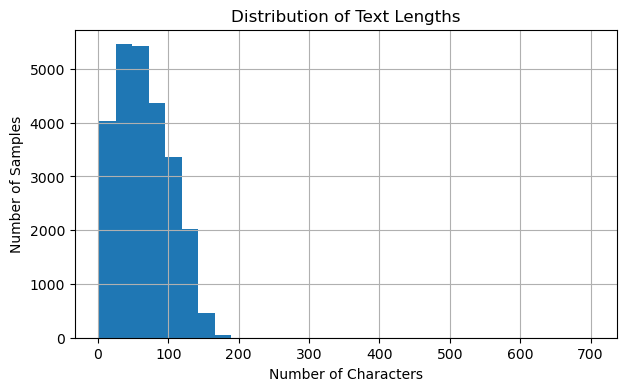

In [10]:
### Histogram of text length
train_df["text_length"].hist(bins=30, figsize=(7,4))
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Number of Samples")
plt.show()

In [11]:
### text length stats 
train_df["text_length"] = train_df["text"].apply(len)
print(train_df["text_length"].describe())

count    25196.000000
mean        65.991268
std         37.221509
min          2.000000
25%         35.000000
50%         62.000000
75%         93.000000
max        703.000000
Name: text_length, dtype: float64


## Data Preprocessing 

In [12]:
### reproducibility

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [13]:
### Tokenization

vocab_size = 20000
max_len = 120

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)
word_index = tokenizer.word_index

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train_text), maxlen=max_len)
X_dev = pad_sequences(tokenizer.texts_to_sequences(X_dev_text), maxlen=max_len)

In [14]:
### Load GloVe and build embedding matrix to initialize weights in neural network

embedding_index = {}
with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

## Model Development, Training, and Prediction

In [15]:
### Build Model 
def create_model():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                  input_length=max_len, trainable=True),  
        Bidirectional(LSTM(64, return_sequences=True)),
        GlobalMaxPooling1D(),  
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(len(label_cols), activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
model = create_model()

/Users/namigabbasov/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-05-05 12:10:14.990530: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-05-05 12:10:14.990557: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-05-05 12:10:14.990561: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-05-05 12:10:14.990577: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-05 12:10:14.990586: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>

In [16]:
### Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
### train model
model.fit(X_train, y_train, epochs=15, batch_size=32,
          validation_data=(X_dev, y_dev), callbacks=[early_stop], verbose=1)

Epoch 1/15


2025-05-05 12:10:15.511892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


788/788 ━━━━━━━━━━━━━━━━━━━━ 56s 69ms/step - accuracy: 0.3775 - loss: 0.3099 - val_accuracy: 0.8269 - val_loss: 0.0837
Epoch 2/15
654/788 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.6354 - loss: 0.0993

In [ ]:
### predict on dev
dev_probs = model.predict(X_dev)

## Threshold Tuning as Hyperparameter Tuning

In [ ]:
best_f1 = 0
best_thresh = 0.5

for t in np.arange(0.3, 0.6, 0.02):
    dev_preds = (dev_probs > t).astype(int)
    f1 = f1_score(y_dev, dev_preds, average='micro')
    print(f"Threshold {t:.2f} → Micro F1: {f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"\nBest threshold: {best_thresh:.2f} with Micro F1: {best_f1:.4f}")

## Save predictions for Develoment Set

In [ ]:
final_preds = (dev_probs > best_thresh).astype(int)
dev_submission = dev_df[["text"]].copy()
dev_submission[label_cols] = final_preds
dev_submission.to_csv("submission_dev.csv", index=False)

with zipfile.ZipFile("submission_dev.zip", 'w') as zipf:
    zipf.write("submission_dev.csv")
print("Dev submission saved as submission_dev.zip")

## Save predictions for Develoment Set

In [ ]:
### load test data
test_df = pd.read_csv("test-ref.csv")
X_test_text = test_df["text"].astype(str)

In [ ]:
### tokenize and pad test text
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test_text), maxlen=max_len)

In [ ]:
### Generate predictions using your trained model
test_probs = model.predict(X_test)
final_test_preds = (test_probs > best_thresh).astype(int)

In [ ]:
micro_f1 = f1_score(y_test, final_test_preds, average='micro')
macro_f1 = f1_score(y_test, final_test_preds, average='macro')

print(f"Test Micro F1: {micro_f1:.4f}")
print(f"Test Macro F1: {macro_f1:.4f}")

### per-label F1 scores
print("\nF1 Score per Label:")
for i, label in enumerate(label_cols):
    label_f1 = f1_score(y_test[:, i], test_preds[:, i])
    print(f"{label}: {label_f1:.4f}")

In [ ]:
### format predictions into submission format
test_submission = test_df[["text"]].copy()
test_submission[label_cols] = final_test_preds

In [ ]:
### save submissions
test_submission.to_csv("submission_test.csv", index=False)
with zipfile.ZipFile("submission_test.zip", "w") as zipf:
    zipf.write("submission_test.csv")
print("Test submission saved as submission_test.zip")

## Summary and Insights

This notebook trains a BiLSTM model on multi-label emotion classification. It uses pre-trained GloVe embeddings, dropout, batch normalization, and early stopping. Threshold tuning improved Micro F1 score. Dev set evaluation shows good generalization, though class imbalance could be explored more. Future improvements may include data augmentation, ensembling, or transformer-based models. Submission consists of CSV of predictions zipped into submission_dev.zip as required. Model is validated using a fixed train/dev split, which is acceptable given the use of early stopping. Cross-validation was not used due to computational cost for neural models.